<a href="https://colab.research.google.com/github/XuXuting/GEOG5990M/blob/main/GEOG5990M_Assessment_0513.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**
Urban green spaces are very important in the daily lives of residents. However, the green spaces distribution may be affected by the economic situation. This may result in poorer groups having less access to green space resources. This study combines the Leeds 2021 deprived households, the public green space data and the administrative boundary data of Leeds for spatial data analysis. The aim is to explore the relationship between them and and provide support for a more equitable allocation of urban green space resources. This project is divided into three parts: data exploration and cleaning, K clustering modeling and results.

# **Data Exploration and Cleaning**
## **Data Description**

This study used three datasets which from public data platforms.

*   Households_Deprivation_Leeds_2021Census_LSOA.xlsx
This is a data on the deprivation dimension of family poverty for Leeds Lower Super Output Areas (LSOA) 2021 from the Office for National Statistics (Nomis) in Excel file format. The poverty dimension variable is a direct measure of poverty, while households in three or four dimensions of it can be considered to disadvantaged socioeconomic status (ONS, 2022).
Link: https://www.nomisweb.co.uk/default.asp

*   GB_GreenspaceSite.shp
This is open green space data in shapefile format from Ordnance Survey data centres and contains all public green spaces in the UK.
Link: https://osdatahub.os.uk/downloads/open/OpenGreenspace

*   LSOA2021_Leeds.shp
This is 2021 LSOA Leeds Boundary vector data in shapefile format from the ONS Open Geography Portal for spatial geographic analysis.
Link: https://geoportal.statistics.gov.uk/datasets/2bbaef5230694f3abae4f9145a3a9800_0/explore?location=52.609880%2C-2.489483%2C6.90

## **Data Exploration**

### Work Environment Configuration
Access data files through the associated Google Drive to meet subsequent analysis needs. Then install necessary Python libraries and packages,and read the datasets.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# installing libraries for aggregation analysis
# install the mapclassify library，it is for spatial data classification
!pip install mapclassify

# it can be index points, lines and surfaces
!pip install rtree

# accelerating geometric calculations
!pip install pygeos

# it wiil be used to add a basemap
!pip install contextily

# it can be used to add a north arrow for spatial visualization results
!pip install git+https://github.com/pmdscully/geo_northarrow.git

  Cloning https://github.com/pmdscully/geo_northarrow.git to /tmp/pip-req-build-sp5vv3d1
  Running command git clone --filter=blob:none --quiet https://github.com/pmdscully/geo_northarrow.git /tmp/pip-req-build-sp5vv3d1
  Resolved https://github.com/pmdscully/geo_northarrow.git to commit 963bdd271707a3bcaa47b2d83d92b88ae0b10950
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# install required packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from geo_northarrow import add_north_arrow

# import the required machine learning packages
from sklearn import cluster
from sklearn.preprocessing import scale

# read data files
# it is  a data on the deprivation dimension of family poverty for Leeds Lower Super Output Areas (LSOA) 2021 from the Office for National Statistics (Nomis) in Excel file format.
# The access time is 6th may
# The access link: https://www.nomisweb.co.uk/default.asp
poverty_households = pd.read_excel('/content/drive/MyDrive/GEOG5990M_Assessment/Households_Deprivation_Leeds_2021Census_LSOA.xlsx')

# it is an open green space data in shapefile format from Ordnance Survey data centres and contains all public green spaces in the UK.
# The access time is 6th may
# The access link: https://osdatahub.os.uk/downloads/open/OpenGreenspace
greenspace = gpd.read_file('/content/drive/MyDrive/GEOG5990M_Assessment/OpenGreenSpace/GB_GreenspaceSite.shp')

# it is 2021 LSOA Leeds Boundary vector data in shapefile format from the ONS Open Geography Portal
# The access time is 6th may
# The access link: https://geoportal.statistics.gov.uk/datasets/2bbaef5230694f3abae4f9145a3a9800_0/explore?location=52.609880%2C-2.489483%2C6.90
leeds = gpd.read_file('/content/drive/MyDrive/GEOG5990M_Assessment/LSOA2021_Leeds/LSOA2021_Leeds.shp')


### Preliminary Exploration

Exploratory analyses can help identify data quality issues. It checks on the data are completed by using a range of data exploration functions. This provides an understanding of the distribution, completeness and potential outliers of the dataset. It can also inform subsequent data cleaning, modelling and visualisation decisions. The results are as follows:
-

*   Households_Deprivation_Leeds_2021Census_LSOA.xlsx contains 488 row;
*   GB_GreenspaceSite.shp contains 16,1954 green polygons and rich geometric information;
*   LSOA2021_Leeds.shp contains 524 row;
*   All numerical poverty variables are of type `int64` and without null value, which provides a good basis for subsequent analyses. The `distName1-4` in greenfield has null values, but these are irrelevant for space. The boundary attributes are complete, except for `LSOA21MNW`, whose 524 null values will be removed prior to merging. Only `LSOA21MNW` in LSOA2021_Leeds.shp has 524 null values but does not affect the analysis.
*   The descriptive statistics show either no deprivation for the majority of households in Leeds. Severe multidimensional deprivation is rare but concentrated, which may be  significant.

Overall, the datasets can support repeatable analyses due to the structure are clear and complete.

In [ ]:
# view first 5 rows of the data to confirm whether the data has been loaded successfully
poverty_households.head()

,Row,Area_Name,Leeds_Code,Total Population,Total Households,Household is not deprived in any dimension,Household is deprived in one dimension,Household is deprived in two dimension,Household is deprived in three dimension,Household is deprived in four dimension
0,1,Leeds 001A,E01011698,1462,632,353,209,61,9,0
1,2,Leeds 001B,E01011699,1289,575,361,173,40,1,0
2,3,Leeds 001C,E01011701,1367,596,357,178,49,12,0
3,4,Leeds 001D,E01011702,1648,664,459,167,33,4,1
4,5,Leeds 001E,E01011703,1224,565,334,191,37,3,0


In [ ]:
greenspace.head()

,id,function,distName1,distName2,distName3,distName4,geometry
0,2BE88E2E-6150-7FED-E063-AAEFA00A0EDD,Play Space,None,None,None,None,"POLYGON Z ((462520.89 1190881.72 0, 462524.51 ..."
1,2BE88E2E-6011-7FED-E063-AAEFA00A0EDD,Cemetery,None,None,None,None,"MULTIPOLYGON Z (((451419.62 1190989.39 0, 4514..."
2,2BE88DD0-F4E8-7FED-E063-AAEFA00A0EDD,Play Space,None,None,None,None,"POLYGON Z ((451031.61 1191230.69 0, 451024.32 ..."
3,2BE88E49-021F-7FED-E063-AAEFA00A0EDD,Cemetery,None,None,None,None,"POLYGON Z ((461911.7 1202923.23 0, 461937.5 12..."
4,2BE88E21-A64D-7FED-E063-AAEFA00A0EDD,Cemetery,None,None,None,None,"POLYGON Z ((456682.07 1204040.27 0, 456666.11 ..."


In [ ]:
leeds.head()

,FID_1,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,Shape__Are,Shape__Len,GlobalID,Shape_Leng,Shape_Area,geometry
0,11051,E01011623,Leeds 075B,None,432083,433331,53.79532,-1.51444,1.773643e+05,2857.411570,3c8ca484-e07d-46a3-80b7-2bcaa856569a,2857.411570,1.773643e+05,"POLYGON ((432271.542 433582.379, 432264.802 43..."
1,10960,E01011525,Leeds 095C,None,426267,428357,53.75094,-1.60315,2.098706e+05,3935.530790,8f70eff1-7224-4d29-a5db-a20a5d0c1f62,3935.530790,2.098706e+05,"POLYGON ((426168.523 428751.345, 426171.867 42..."
2,10720,E01011264,Leeds 011A,None,420937,441836,53.87233,-1.68306,6.373247e+05,5076.727907,e4ed2f01-7253-4c5a-ba48-c2778526dc67,5076.727907,6.373247e+05,"POLYGON ((421564.647 442169.989, 421528 442150..."
3,30852,E01032503,Leeds 007E,None,423606,442156,53.87509,-1.64245,1.285020e+07,21356.788090,e849abe0-8297-4c5c-8f0b-a6313fcaaa95,21356.788090,1.285020e+07,"POLYGON ((421564.647 442169.989, 421445.188 44..."
4,11077,E01011651,Leeds 020B,None,432379,439319,53.84912,-1.50932,4.079808e+05,5801.895319,a6215bb9-07d7-4290-9203-d8bc7fde3b4f,5801.895319,4.079808e+05,"POLYGON ((432359.892 438863.054, 432361.786 43..."


In [ ]:
# view the columns of the data
poverty_households.columns

Index(['Row', 'Area_Name', 'Leeds_Code', 'Total Population',
       'Total Households', 'Household is not deprived in any dimension',
       'Household is deprived in one dimension',
       'Household is deprived in two dimension',
       'Household is deprived in three dimension',
       'Household is deprived in four dimension'],
      dtype='object')

In [ ]:
greenspace.columns

Index(['id', 'function', 'distName1', 'distName2', 'distName3', 'distName4',
       'geometry'],
      dtype='object')

In [ ]:
leeds.columns

Index(['FID_1', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT',
       'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

In [ ]:
# view the type of the data
poverty_households.dtypes

,0
Row,int64
Area_Name,object
Leeds_Code,object
Total Population,int64
Total Households,int64
Household is not deprived in any dimension,int64
Household is deprived in one dimension,int64
Household is deprived in two dimension,int64
Household is deprived in three dimension,int64
Household is deprived in four dimension,int64


In [ ]:
greenspace.dtypes

,0
id,object
function,object
distName1,object
distName2,object
distName3,object
distName4,object
geometry,geometry


In [ ]:
leeds.dtypes

,0
FID_1,int64
LSOA21CD,object
LSOA21NM,object
LSOA21NMW,object
BNG_E,int64
BNG_N,int64
LAT,float64
LONG,float64
Shape__Are,float64
Shape__Len,float64


In [ ]:
# check the entire dataset structure and quality
poverty_households.info

<bound method DataFrame.info of      Row   Area_Name Leeds_Code  Total Population  Total Households  \
0      1  Leeds 001A  E01011698              1462               632   
1      2  Leeds 001B  E01011699              1289               575   
2      3  Leeds 001C  E01011701              1367               596   
3      4  Leeds 001D  E01011702              1648               664   
4      5  Leeds 001E  E01011703              1224               565   
..   ...         ...        ...               ...               ...   
483  484  Leeds 111E  E01033016              1047               703   
484  485  Leeds 112A  E01011467              1992               815   
485  486  Leeds 112B  E01011468              2031               918   
486  487  Leeds 112C  E01011470              1294               599   
487  488  Leeds 112F  E01035054              2569              1380   

     Household is not deprived in any dimension  \
0                                           353   
1                                           361   
2                                           357   
3                                           459   
4                                           334   
..                                          ...   
483                                         480   
484                                         392   
485                                         375   
486                                         219   
487                                        1052   

     Household is deprived in one dimension  \
0                                       209   
1                                       173   
2                                       178   
3                                       167   
4                                       191   
..                                      ...   
483                                     158   
484                                     255   
485                                     284   
486                                     215   
487                                     277   

     Household is deprived in two dimension  \
0                                        61   
1                                        40   
2                                        49   
3                                        33   
4                                        37   
..                                      ...   
483                                      42   
484                                     126   
485                                     177   
486                                     122   
487                                      47   

     Household is deprived in three dimension  \
0                                           9   
1                                           1   
2                                          12   
3                                           4   
4                                           3   
..                                        ...   
483                                        20   
484                                        41   
485                                        76   
486                                        41   
487                                         4   

     Household is deprived in four dimension  
0                                          0  
1                                          0  
2                                          0  
3                                          1  
4                                          0  
..                                       ...  
483                                        3  
484                                        1  
485                                        6  
486                                        2  
487                                        0  

[488 rows x 10 columns]>

In [ ]:
greenspace.info

<bound method DataFrame.info of                                           id               function distName1  \
0       2BE88E2E-6150-7FED-E063-AAEFA00A0EDD             Play Space      None   
1       2BE88E2E-6011-7FED-E063-AAEFA00A0EDD               Cemetery      None   
2       2BE88DD0-F4E8-7FED-E063-AAEFA00A0EDD             Play Space      None   
3       2BE88E49-021F-7FED-E063-AAEFA00A0EDD               Cemetery      None   
4       2BE88E21-A64D-7FED-E063-AAEFA00A0EDD               Cemetery      None   
...                                      ...                    ...       ...   
161949  2BE88DD7-0043-7FED-E063-AAEFA00A0EDD             Play Space      None   
161950  2BE88DD3-ECB3-7FED-E063-AAEFA00A0EDD  Other Sports Facility      None   
161951  2BE88E89-0500-7FED-E063-AAEFA00A0EDD  Other Sports Facility      None   
161952  2BE88DD2-A3C2-7FED-E063-AAEFA00A0EDD             Play Space      None   
161953  2BE88DCE-3340-7FED-E063-AAEFA00A0EDD  Public Park Or Garden      None   

       distName2 distName3 distName4  \
0           None      None      None   
1           None      None      None   
2           None      None      None   
3           None      None      None   
4           None      None      None   
...          ...       ...       ...   
161949      None      None      None   
161950      None      None      None   
161951      None      None      None   
161952      None      None      None   
161953      None      None      None   

                                                 geometry  
0       POLYGON Z ((462520.89 1190881.72 0, 462524.51 ...  
1       MULTIPOLYGON Z (((451419.62 1190989.39 0, 4514...  
2       POLYGON Z ((451031.61 1191230.69 0, 451024.32 ...  
3       POLYGON Z ((461911.7 1202923.23 0, 461937.5 12...  
4       POLYGON Z ((456682.07 1204040.27 0, 456666.11 ...  
...                                                   ...  
161949  POLYGON Z ((137908.43 23831.48 0, 137909.21 23...  
161950  POLYGON Z ((137901.51 23900.49 0, 137882.25 23...  
161951  POLYGON Z ((134392.26 25018.68 0, 134363.3 250...  
161952  POLYGON Z ((134348.97 25064.5 0, 134352.06 250...  
161953  POLYGON Z ((134352.06 25074.57 0, 134348.97 25...  

[161954 rows x 7 columns]>

In [ ]:
leeds.info

<bound method DataFrame.info of      FID_1   LSOA21CD    LSOA21NM LSOA21NMW   BNG_E   BNG_N       LAT  \
0    11051  E01011623  Leeds 075B      None  432083  433331  53.79532   
1    10960  E01011525  Leeds 095C      None  426267  428357  53.75094   
2    10720  E01011264  Leeds 011A      None  420937  441836  53.87233   
3    30852  E01032503  Leeds 007E      None  423606  442156  53.87509   
4    11077  E01011651  Leeds 020B      None  432379  439319  53.84912   
..     ...        ...         ...       ...     ...     ...       ...   
519  10996  E01011565  Leeds 015C      None  430663  440254  53.85763   
520  11122  E01011704  Leeds 002C      None  441486  447928  53.92585   
521  10984  E01011553  Leeds 108D      None  428465  426220  53.73162   
522  10817  E01011368  Leeds 082C      None  429141  431944  53.78303   
523  10953  E01011518  Leeds 093A      None  427407  429727  53.76320   

        LONG    Shape__Are    Shape__Len  \
0   -1.51444  1.773643e+05   2857.411570   
1   -1.60315  2.098706e+05   3935.530790   
2   -1.68306  6.373247e+05   5076.727907   
3   -1.64245  1.285020e+07  21356.788090   
4   -1.50932  4.079808e+05   5801.895319   
..       ...           ...           ...   
519 -1.53531  4.566428e+05   4841.287941   
520 -1.36973  6.588482e+06  22469.153961   
521 -1.57001  3.540778e+05   5345.401755   
522 -1.55923  1.408940e+05   2214.728525   
523 -1.58574  8.712401e+05   6063.803993   

                                 GlobalID    Shape_Leng    Shape_Area  \
0    3c8ca484-e07d-46a3-80b7-2bcaa856569a   2857.411570  1.773643e+05   
1    8f70eff1-7224-4d29-a5db-a20a5d0c1f62   3935.530790  2.098706e+05   
2    e4ed2f01-7253-4c5a-ba48-c2778526dc67   5076.727907  6.373247e+05   
3    e849abe0-8297-4c5c-8f0b-a6313fcaaa95  21356.788090  1.285020e+07   
4    a6215bb9-07d7-4290-9203-d8bc7fde3b4f   5801.895319  4.079808e+05   
..                                    ...           ...           ...   
519  a1f8923d-41f5-428f-bd1b-0fa9604162f5   4841.287941  4.566428e+05   
520  18ceb907-3b65-4a4e-9c60-5263c9463100  22469.198851  6.588481e+06   
521  6a391548-9cd9-46d6-a48a-11977ee7c053   5345.401755  3.540778e+05   
522  cff40db5-741e-4af8-8c70-0354aeb910de   2214.728525  1.408940e+05   
523  076b505b-865b-4e21-b9b0-daffbf698eda   6063.803993  8.712401e+05   

                                              geometry  
0    POLYGON ((432271.542 433582.379, 432264.802 43...  
1    POLYGON ((426168.523 428751.345, 426171.867 42...  
2    POLYGON ((421564.647 442169.989, 421528 442150...  
3    POLYGON ((421564.647 442169.989, 421445.188 44...  
4    POLYGON ((432359.892 438863.054, 432361.786 43...  
..                                                 ...  
519  POLYGON ((430989 440149, 430977.327 440152.335...  
520  POLYGON ((443381.688 450063.5, 443376.004 4500...  
521  POLYGON ((428437.084 426432, 428444.088 426412...  
522  POLYGON ((429029 432065.5, 429029 432061, 4290...  
523  POLYGON ((427124.5 430181, 427126.5 430175.094...  

[524 rows x 14 columns]>

In [ ]:
# check the value of each row is null or not and to know the total number of null rows
poverty_households.isnull().sum()

,0
Row,0
Area_Name,0
Leeds_Code,0
Total Population,0
Total Households,0
Household is not deprived in any dimension,0
Household is deprived in one dimension,0
Household is deprived in two dimension,0
Household is deprived in three dimension,0
Household is deprived in four dimension,0


In [ ]:
greenspace.isnull().sum()

,0
id,0
function,0
distName1,116778
distName2,161602
distName3,161946
distName4,161953
geometry,0


In [ ]:
leeds.isnull().sum()

,0
FID_1,0
LSOA21CD,0
LSOA21NM,0
LSOA21NMW,524
BNG_E,0
BNG_N,0
LAT,0
LONG,0
Shape__Are,0
Shape__Len,0


In [ ]:
# generate statistics summaries of numeric columns to determine the distribution, range, and presence of outliers of the variable
poverty_households.describe()

,Row,Total Population,Total Households,Household is not deprived in any dimension,Household is deprived in one dimension,Household is deprived in two dimension,Household is deprived in three dimension,Household is deprived in four dimension
count,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000
mean,244.500000,1663.846311,699.729508,338.002049,230.235656,100.571721,28.940574,1.979508
std,141.017729,327.975901,136.456703,111.406585,49.711155,46.598320,22.774011,2.432580
min,1.000000,1042.000000,430.000000,105.000000,126.000000,19.000000,1.000000,0.000000
25%,122.750000,1461.750000,613.000000,256.750000,196.000000,63.000000,10.000000,0.000000
50%,244.500000,1607.500000,672.500000,326.000000,225.000000,92.000000,21.000000,1.000000
75%,366.250000,1790.000000,758.500000,403.250000,257.250000,134.000000,44.250000,3.000000
max,488.000000,4342.000000,1380.000000,1052.000000,473.000000,265.000000,106.000000,15.000000


In [ ]:
greenspace.describe()

,id,function,distName1,distName2,distName3,distName4,geometry
count,161954,161954,45176,352,8,1,161954
unique,161954,10,27660,345,8,1,161879
top,2BE88DCE-3340-7FED-E063-AAEFA00A0EDD,Play Space,St Mary's Church,Christ Church,The Old Golf Course,<Null>,"POLYGON Z ((533044.36 194003.06 0, 533051.15 1..."
freq,1,44296,2128,3,1,1,2


In [ ]:
leeds.describe()

,FID_1,BNG_E,BNG_N,LAT,LONG,Shape__Are,Shape__Len,Shape_Leng,Shape_Area
count,524.000000,524.000000,524.000000,524.000000,524.000000,5.240000e+02,524.000000,524.000000,5.240000e+02
mean,13234.461832,429727.007634,434990.242366,53.810334,-1.550056,1.984000e+06,6750.446223,5403.841033,1.052910e+06
std,6424.022433,6377.441719,5361.622186,0.048215,0.096835,6.906137e+06,6883.089789,4202.562236,2.404922e+06
min,10045.000000,412764.000000,422102.000000,53.694600,-1.807350,6.841824e+04,1468.561952,0.834338,4.469999e-04
25%,10833.750000,425287.250000,431515.750000,53.779358,-1.617645,2.949397e+05,3683.473919,3355.389443,2.610911e+05
50%,10964.500000,429405.500000,434871.000000,53.809385,-1.554920,4.499067e+05,4787.265621,4489.536006,3.919106e+05
75%,11095.250000,433418.750000,437927.000000,53.836820,-1.494575,1.055203e+06,6710.294772,6110.942968,7.576408e+05
max,33049.000000,448566.000000,454669.000000,53.986360,-1.263410,9.239496e+07,64102.166609,30782.077776,2.551487e+07


## **Data Preprocessing**



The histogram showing the distribution of data according to the level of poverty and the total number of families in Leeds presents a more extreme situation for multi-dimensional deprived families, suggesting that subsequent analysis should be converted to proportional indicators.

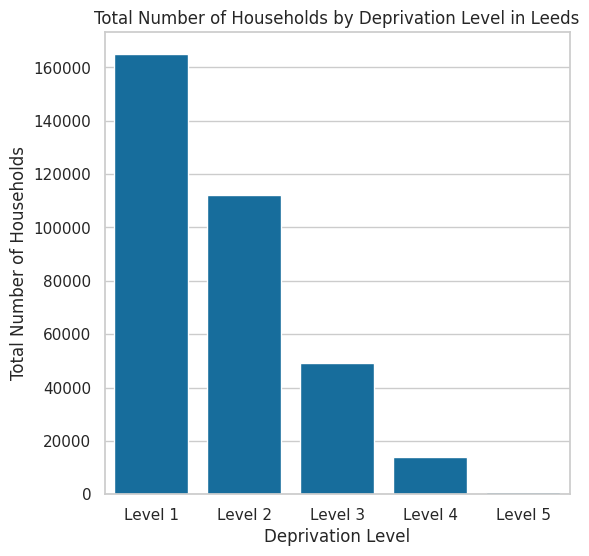

In [ ]:
# count the total number of households in each poverty level
sums_levels = poverty_households[['Household is not deprived in any dimension',
                  'Household is deprived in one dimension',
                  'Household is deprived in two dimension',
                  'Household is deprived in three dimension',
                  'Household is deprived in four dimension']].sum()

# generate an index for each statistical number to support the production of a visual graph
sums_levels = sums_levels.reset_index()

# rename the columns
sums_levels.columns = ['Deprivation Level', 'Households']
sums_levels['Deprivation Level'] = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

# graph size and style
f, ax=plt.subplots(figsize=(6,6))
sns.set_theme(style="whitegrid", palette="colorblind")

# creat a barplot
sns.barplot(x='Deprivation Level',y='Households',data=sums_levels)

# add title and labels
plt.title('Total Number of Households by Deprivation Level in Leeds')
plt.xlabel('Deprivation Level')
plt.ylabel('Total Number of Households')

# show the
plt.show()

In [ ]:
# merge LSOA2021_Leeds with the Census2021_Leeds data to produce a new data frame containing information on both leeds_census
leeds_poverty_households = leeds.merge(poverty_households, left_on='LSOA21CD', right_on='Leeds_Code', how='left')
print(leeds_poverty_households.shape)

(524, 24)


In [ ]:
# Check the Coordinate Reference Systems (CRS)
print(greenspace.crs,leeds.crs)

EPSG:27700 EPSG:27700


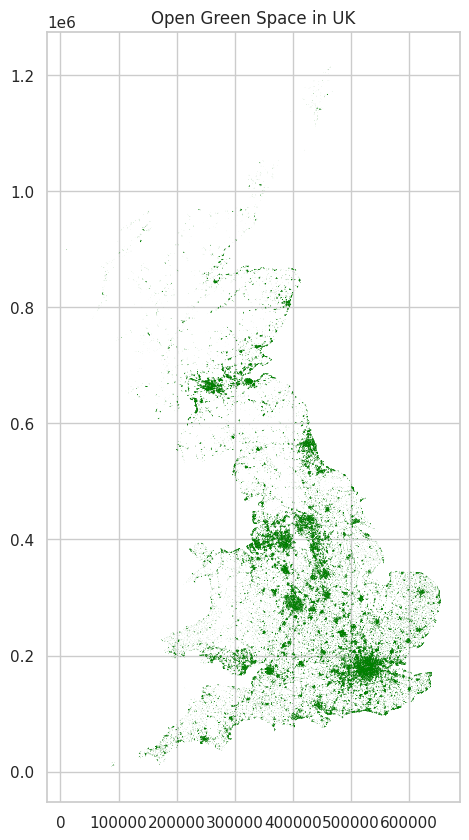

In [ ]:
# visualize green space data to provide evidence for the next step of clipping
# plot the image with size and style
greenspace.plot(figsize=(10, 10),color='green',edgecolor='green',linewidth=0.2)
plt.title("Open Green Space in UK")
plt.show()

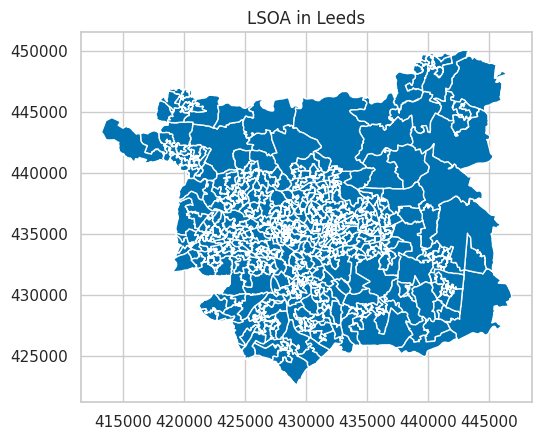

In [ ]:
# visualize Leeds boundary data to provide evidence for the next step of clipping
# plot the image with size and style
leeds.plot()
plt.title("LSOA in Leeds")
plt.show()

The spatial maps can be used to support data cleaning through visual comparison. First, the visualization and superposition of green space data and Leeds boundary data will intuitively compare the data range and support the rationality of cropping. Second, it verifies the CRS consistency.

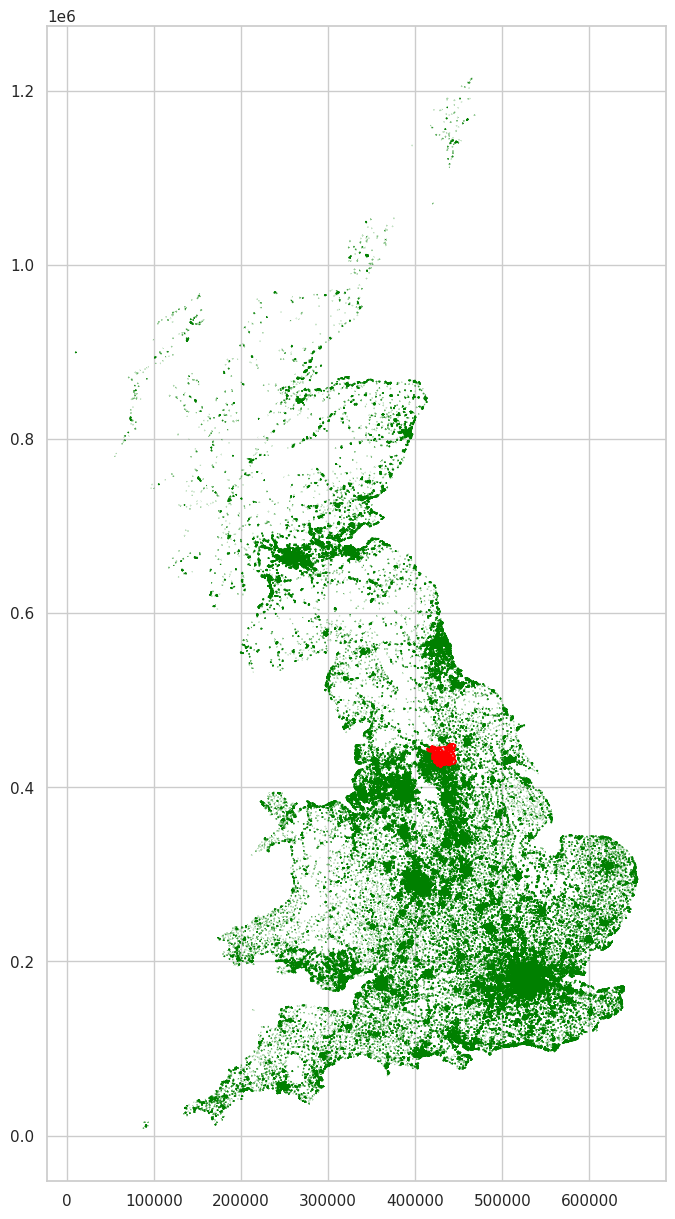

In [ ]:
# visualize and overlay Leeds boundary data and green space data to provide evidence for the next step of clipping
# plot a subplot with dimensions 15 X 15
f, ax = plt.subplots(1, figsize=(15, 15))

# define the basemap plot it on the sublot axis
base = greenspace.plot(ax=ax,color='green',edgecolor='green', alpha=1)

# Plot the bus stops on the basemap axis, colour the bus stops red
leeds.plot(ax=base,color='lightgrey',edgecolor='red')

# Show the map
plt.show()

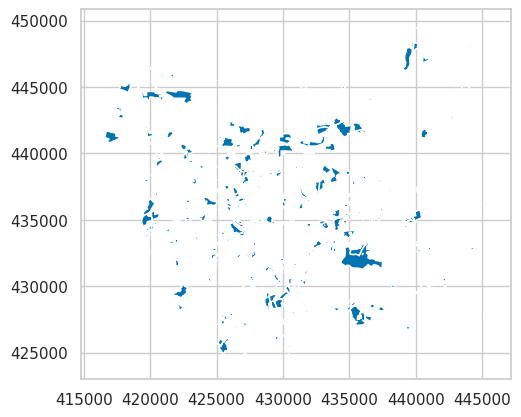

In [ ]:
# the extent of the grean space is larger than that of leeds
# leeds extent was used as a clipping criterion to clip the in-range data for grean space.
greenspace_leeds = gpd.clip(greenspace, leeds)
# show the range of green space in leeds
greenspace_leeds.plot()
plt.show()

In [268]:
# save the greensapce data to .geojson
greenspace_leeds.to_file('/content/drive/MyDrive/GEOG5990M_Assessment/greenspace_leeds.geojson', driver='GeoJSON')

In [ ]:
# LSOA Leeds boundary data and greenspace data spatial join to assign LSOA information to greenspace
greenspace_with_leeds = gpd.sjoin(greenspace, leeds, how='inner', predicate='within')

In [ ]:
# view the fields of leeds_poverty_households
leeds_poverty_households.columns

Index(['FID_1', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT',
       'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'Shape_Leng',
       'Shape_Area', 'geometry', 'Row', 'Area_Name', 'Leeds_Code',
       'Total Population', 'Total Households',
       'Household is not deprived in any dimension',
       'Household is deprived in one dimension',
       'Household is deprived in two dimension',
       'Household is deprived in three dimension',
       'Household is deprived in four dimension'],
      dtype='object')

In [ ]:
# view the greenspace_leeds
greenspace_leeds.columns

Index(['id', 'function', 'distName1', 'distName2', 'distName3', 'distName4',
       'geometry'],
      dtype='object')

In [ ]:
# view the greenspace_with_leeds
greenspace_with_leeds.columns

Index(['id', 'function', 'distName1', 'distName2', 'distName3', 'distName4',
       'geometry', 'index_right', 'FID_1', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW',
       'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID',
       'Shape_Leng', 'Shape_Area'],
      dtype='object')

**Variable selection and calculation**
Norman et al. (2024) shown that using standardized percentage variables for spatial analysis at the small area level can reveal spatial patterns of poverty. Four variables are created to build a link between social and environment:
*   'Severe_Deprivation_Households' is the sum of households deprived in three and four dimensions households. It reflects multi poverty(ONS, 2022).
*   'Deprivation_Percentage' expresses deprivation proportion, which can reflect accurately the degree of each regional economic vulnerability and can be used as a key variable to measure the spatial distribution of poverty.
*   'lsoa_area_m²'represents area of each LSOA polygon.
*   'greenspace_percentage'. The LSOA without green space is replaced by 0 to avoid NaNs and preserve analytical completeness (Pandas, 2024).

'Deprivation_Percentage' and 'greenspace_percentage' can eliminate the impacts in population and area, which is convenient for comparison (Buckley, 2013). These standardized percentage variables form the basis for subsequent clustering and visualization.

Besides, delete old area fields and validate dtypes before merging again to avoid duplicate fields and type errors and improve code stability and reproducibility.

In [ ]:
# calculate the number of poor households in each region and the percentage of poor households in the total number of households
# severely deprived households are created by adding together the number of households with poverty deprivation dimensions 3 and 4
leeds_poverty_households['Severe_Deprivation_Households'] = (
    leeds_poverty_households['Household is deprived in three dimension'] +
    leeds_poverty_households['Household is deprived in four dimension'])

# calculate the proportion of households in severe poverty
leeds_poverty_households['Deprivation_Percentage'] = (
    leeds_poverty_households['Severe_Deprivation_Households'] /
    leeds_poverty_households['Total Households']) * 100

print(leeds_poverty_households['Deprivation_Percentage'])

0      10.271041
1       3.586801
2       3.466205
3       0.328407
4       3.291536
         ...    
519     1.505017
520     4.454148
521     1.794454
522    10.000000
523     2.700000
Name: Deprivation_Percentage, Length: 524, dtype: float64


In [ ]:
# calculate the area of each LSOA
leeds['lsoa_area_m2'] = leeds.geometry.area
print(leeds['lsoa_area_m2'].reset_index)

<bound method Series.reset_index of 0      1.773643e+05
1      2.098706e+05
2      6.373247e+05
3      1.285020e+07
4      4.079808e+05
           ...     
519    4.566428e+05
520    6.588481e+06
521    3.540778e+05
522    1.408940e+05
523    8.712401e+05
Name: lsoa_area_m2, Length: 524, dtype: float64>


In [ ]:
# calculate the area of ​​green space of each LSOA in Leeds (m²)
greenspace_with_leeds['area_m²'] = greenspace_with_leeds.geometry.area
lsoa_greenspace_area = greenspace_with_leeds.groupby('LSOA21CD')['area_m²'].sum().reset_index()
print(lsoa_greenspace_area)

      LSOA21CD       area_m²
0    E01011264   11127.18615
1    E01011265   30976.96355
2    E01011266  163899.05260
3    E01011267   39214.99840
4    E01011268     275.66060
..         ...           ...
345  E01035049     810.09340
346  E01035051    7824.48705
347  E01035052   25877.63350
348  E01035053   23327.98890
349  E01035054    4912.67590

[350 rows x 2 columns]


In [ ]:
# run it to avoid generating duplicate fields that cause operation failure
leeds = leeds.drop(columns=['area_m²', 'area_m²_x', 'area_m²_y','greenspace_percentage'], errors='ignore')

In [ ]:
# merge the total green space area to the Leeds boundary data
leeds = leeds.merge(lsoa_greenspace_area, on='LSOA21CD', how='left')
leeds.head()

,FID_1,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,Shape__Are,Shape__Len,GlobalID,Shape_Leng,Shape_Area,geometry,lsoa_area_m2,area_m²
0,11051,E01011623,Leeds 075B,None,432083,433331,53.79532,-1.51444,1.773643e+05,2857.411570,3c8ca484-e07d-46a3-80b7-2bcaa856569a,2857.411570,1.773643e+05,"POLYGON ((432271.542 433582.379, 432264.802 43...",1.773643e+05,16491.78245
1,10960,E01011525,Leeds 095C,None,426267,428357,53.75094,-1.60315,2.098706e+05,3935.530790,8f70eff1-7224-4d29-a5db-a20a5d0c1f62,3935.530790,2.098706e+05,"POLYGON ((426168.523 428751.345, 426171.867 42...",2.098706e+05,227.33250
2,10720,E01011264,Leeds 011A,None,420937,441836,53.87233,-1.68306,6.373247e+05,5076.727907,e4ed2f01-7253-4c5a-ba48-c2778526dc67,5076.727907,6.373247e+05,"POLYGON ((421564.647 442169.989, 421528 442150...",6.373247e+05,11127.18615
3,30852,E01032503,Leeds 007E,None,423606,442156,53.87509,-1.64245,1.285020e+07,21356.788090,e849abe0-8297-4c5c-8f0b-a6313fcaaa95,21356.788090,1.285020e+07,"POLYGON ((421564.647 442169.989, 421445.188 44...",1.285020e+07,30337.46910
4,11077,E01011651,Leeds 020B,None,432379,439319,53.84912,-1.50932,4.079808e+05,5801.895319,a6215bb9-07d7-4290-9203-d8bc7fde3b4f,5801.895319,4.079808e+05,"POLYGON ((432359.892 438863.054, 432361.786 43...",4.079808e+05,NaN


In [ ]:
# for areas without green space, the green space area is assigned a value of 0.
# ##### ChatGPT 4o #####
# The following prompt was used in ChatGPT 4o to replace NaN:
# "Is there any formula in Python that can replace null values ​​with data?"
# "In Python's pandas library, you can use the .fillna()， where() ,  apply()， interpolate()  to replace missing values (NaN)."
# Then I check the pandas.DataFrame.dtypes(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dtypes.html) to learn it.

leeds['area_m²'] = leeds['area_m²'].fillna(0)
leeds.head()

,FID_1,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,Shape__Are,Shape__Len,GlobalID,Shape_Leng,Shape_Area,geometry,lsoa_area_m2,area_m²
0,11051,E01011623,Leeds 075B,None,432083,433331,53.79532,-1.51444,1.773643e+05,2857.411570,3c8ca484-e07d-46a3-80b7-2bcaa856569a,2857.411570,1.773643e+05,"POLYGON ((432271.542 433582.379, 432264.802 43...",1.773643e+05,16491.78245
1,10960,E01011525,Leeds 095C,None,426267,428357,53.75094,-1.60315,2.098706e+05,3935.530790,8f70eff1-7224-4d29-a5db-a20a5d0c1f62,3935.530790,2.098706e+05,"POLYGON ((426168.523 428751.345, 426171.867 42...",2.098706e+05,227.33250
2,10720,E01011264,Leeds 011A,None,420937,441836,53.87233,-1.68306,6.373247e+05,5076.727907,e4ed2f01-7253-4c5a-ba48-c2778526dc67,5076.727907,6.373247e+05,"POLYGON ((421564.647 442169.989, 421528 442150...",6.373247e+05,11127.18615
3,30852,E01032503,Leeds 007E,None,423606,442156,53.87509,-1.64245,1.285020e+07,21356.788090,e849abe0-8297-4c5c-8f0b-a6313fcaaa95,21356.788090,1.285020e+07,"POLYGON ((421564.647 442169.989, 421445.188 44...",1.285020e+07,30337.46910
4,11077,E01011651,Leeds 020B,None,432379,439319,53.84912,-1.50932,4.079808e+05,5801.895319,a6215bb9-07d7-4290-9203-d8bc7fde3b4f,5801.895319,4.079808e+05,"POLYGON ((432359.892 438863.054, 432361.786 43...",4.079808e+05,0.00000


In [ ]:
# calculate the percentage of green space in each area
leeds['greenspace_percentage'] = leeds['area_m²']/leeds['lsoa_area_m2']*100
print(leeds['greenspace_percentage'])

0      9.298251
1      0.108320
2      1.745921
3      0.236086
4      0.000000
         ...   
519    0.000000
520    2.792556
521    0.000000
522    1.562074
523    6.455484
Name: greenspace_percentage, Length: 524, dtype: float64


# **K-means Clustering**


This study uses the K-means clustering model to divide the LSOA areas of Leeds into groups with different characteristics based on 'the proportion of severe poverty families' and 'greenspace coverage'. This model is a reasonable choice for this study because it is computationally efficient and intuitive (Jain, 2010).

K-means clustering has significant advantages. First, it automatically divides LSOA into several groups according to the characteristics of the data itself, without setting thresholds artificially (MacQueen, 1967). Second, it is highly interpretable because each group is summarized with a pair of averages that policy makers can understand at a glance (Spielman and Thill, 2008). Finally, it is robust in that the distance calculation is not affected by differences in the size of the numbers (Xu and Wunsch, 2005).

It can reveal the spatial relationship between social vulnerability and resource accessibility. The model determines K=4 as the optimal number of clusters by the elbow method. If the number continues to increase, the effect on reducing error is not significant.

In [ ]:
# merge the greenspace_percentage field from the leeds table into the poverty-focused leeds_poverty_households table to form a new leeds_merged table
leeds_merged = leeds_poverty_households.merge(leeds[['LSOA21CD', 'greenspace_percentage']],on='LSOA21CD',how='left')

# choose greenspace_percentage and Deprivation_Percentage as variables to analisis
clustering_data = leeds_merged[['LSOA21CD', 'greenspace_percentage', 'Deprivation_Percentage']]
print(clustering_data.isnull().sum())

LSOA21CD                   0
greenspace_percentage      0
Deprivation_Percentage    36
dtype: int64


In [ ]:
# delete rows with NaN
clustering_data = clustering_data.dropna()

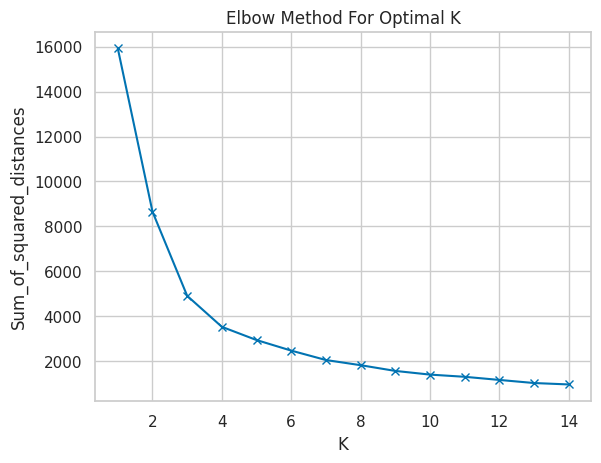

In [ ]:
# creat for K-means clustering
clustering_K = clustering_data[['greenspace_percentage', 'Deprivation_Percentage']]

# creat an empty list to be filled with values ​​later
Sum_of_squared_distances = []

# set range of K
K = range(1, 15)

# run KMeans clustering and record inertia
for k in K:
    KM = cluster.KMeans(n_clusters=k, init='random', random_state=123)
    KM.fit(clustering_K.values)
    Sum_of_squared_distances.append(KM.inertia_)

# plot a line chart
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal K')
plt.show()

In [ ]:
# K=4 is the turning point of the trend of the elbow line
KM4 = cluster.KMeans(n_clusters=4,init="random", random_state=123)
KM4cls = KM4.fit(clustering_data[['greenspace_percentage', 'Deprivation_Percentage']].values)



*   Cluster 0 has high poverty and low greenspace.
*   Cluster 1 has low poverty and low greenspace. It may be industrial area
*   Cluster 2 has low poverty and many greenspace. It may be affluent suburban.
*   Cluster 3 has moderate poverty and greenspace. It may be mixed area.






In [ ]:
# 查看每个LSOA中的等级
# view the cluster labels for each LSOA
KM4cls.labels_

array([2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 3, 1, 1, 0, 2, 0, 1, 1, 2, 0, 1, 1,
       1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 1, 3, 1, 0,
       1, 1, 1, 3, 2, 1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 1, 2, 0,
       0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 3, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 3, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0,
       1, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 3, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 3, 1, 2, 1, 1, 1, 1, 3, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 0, 0, 2, 1,
       0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 2, 2,
       1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 3, 0, 1, 1, 2, 1, 1, 0, 1, 0,

# **Result**
## **Non-spatial Visualization**

This scatter diagram uses Severe Deprivation Rate (%) as the vertical axis and Greenspace Coverage (%) as the horizontal axis. The different colors are used to represent K-means clustering results based on clustering labels. The distribution of points does not show a clear linear trend. The proportion of green space in most areas is concentrated in 0-5%, while the severe poverty rate fluctuates between 0% and 15%. Overall, the chart indicates that there may be a certain negative correlation between the proportion of green space and the degree of poverty, although the correlation is not strong. It needs to further analysis for validation.

It effectively show the correlation and distribution between variables. It helps reveal group characteristics and improve interpretability. The use of the viridis color palette also enhances the readability of images, especially for colorblind users (Nuñez et al., 2018). However, the limitation of this map its cannot to reveal the geographical distribution of clusters in space. The evidence for research objectives is still not enough. Especially under the complex background, It is difficult to judge whether there is poverty and green space inequality only by the distribution of these values. Spatial and geographical presentation helps achieve research objectives (Bhatt and Wallgrün, 2014)

In [ ]:
# run it to avoid generating duplicate fields that cause operation failure
leeds_merged = leeds_merged.drop(columns=['cluster'], errors='ignore')

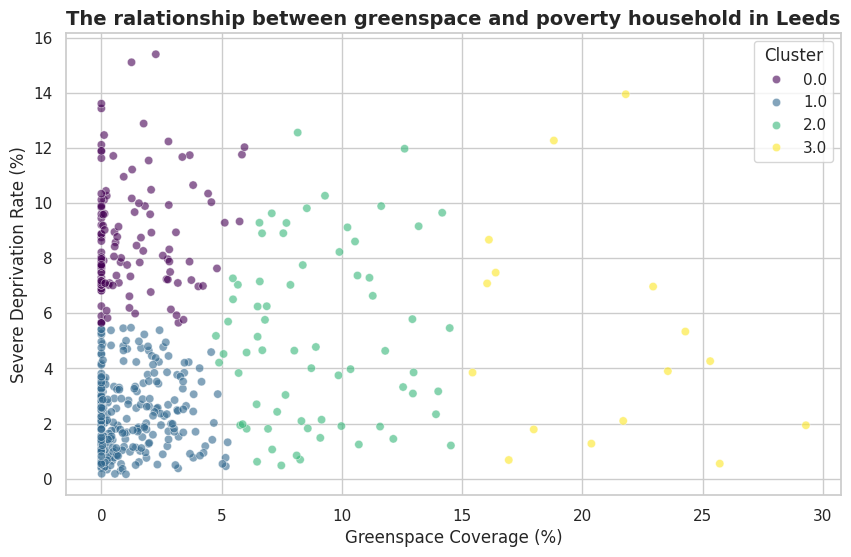

In [ ]:
# creat a new colum to add the clustering result to clustering_data
clustering_data['cluster'] = KM4cls.labels_

# add cluser result to leeds_merged as a new columns
leeds_merged = leeds_merged.merge(clustering_data[['LSOA21CD', 'cluster']],on='LSOA21CD',how='left')

# add Deprivation_Percentage value to leeds_merged as a new columns
leeds_merged['Deprivation_Percentage'] = leeds_poverty_households['Deprivation_Percentage'].values

# set size
plt.figure(figsize=(10, 6))

# plot a scatter
sns.scatterplot(x='greenspace_percentage',y='Deprivation_Percentage',hue='cluster',data=leeds_merged,palette='viridis',alpha=0.6)

# add tilte and labels
plt.title("The ralationship between greenspace and poverty household in Leeds", fontsize=14, weight='bold')
plt.xlabel('Greenspace Coverage (%)')
plt.ylabel('Severe Deprivation Rate (%)')
plt.legend(title='Cluster', loc='best')
plt.grid(True)

# show the scatter plot
plt.show()

## **Spatial Visualization**

This figure visually presents the spatial relationship between areas of different poverty levels and the distribution of green Spaces by means of spatial superposition. The spatial pattern can be observed effectively by overlaying the green space layer on the LSOA area, which is coded according to the ten equal parts. In addition, different color and legends are used in the map to distinguish each area level so that the map has strong interpretability and analytical value (Harrower and Brewer, 2003).

However, it still has limitations. First of all, the figure can not to show the proportion of green land corresponding to the poverty level. It limits the in-depth analysis of the correlation between them. Second, the judgment of the correlation is too dependent on vision. The results of spatial visualization itself cannot directly support the establishment of the relationship between the two (Goodchild, 1987). Although cluster analysis has been done in this study, it cannot be directly reflected on a graph, and the chaotic color will seriously reduce the explanatory power. This limitation makes it impossible to intuitively judge the geographical distribution characteristics of each cluster group. It limits the interpretation and analysis of spatial inequality.

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


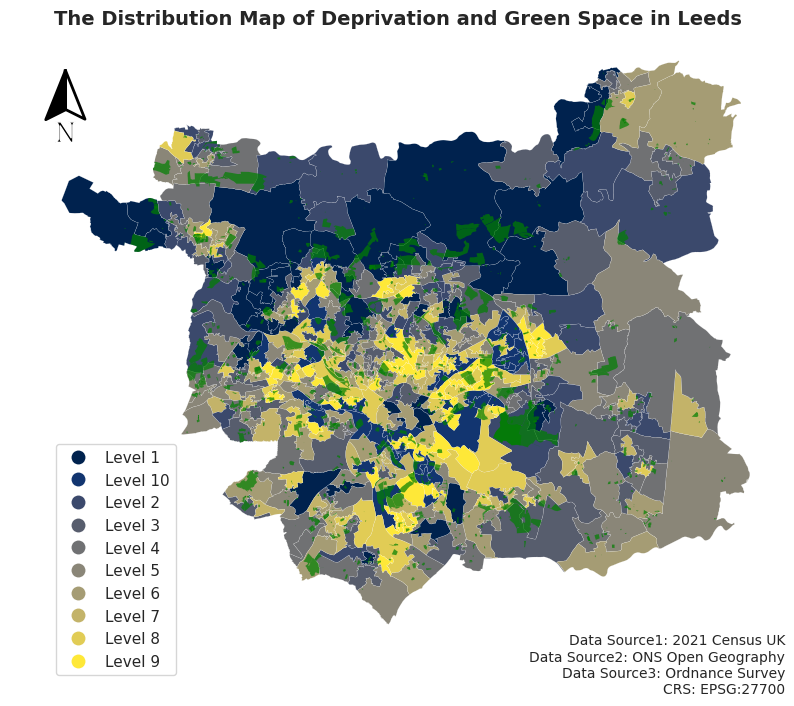

In [ ]:
# divide the data into 10 equal parts
leeds_poverty_households['Deprivation_Level'] = pd.qcut(leeds_poverty_households['Deprivation_Percentage'], q=10,
    labels=['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5', 'Level 6', 'Level 7', 'Level 8', 'Level 9', 'Level 10'])

# delete NaN
leeds_poverty_households = leeds_poverty_households.dropna(subset=['Deprivation_Level'])

# convert deprivation levels to strings to ease classification mapping
leeds_poverty_households['Deprivation_Level'] = leeds_poverty_households['Deprivation_Level'].astype(str)

# create a for loop for plotting a map of each area
leeds_poverty_households_cols = ['Deprivation_Level']

# for each item in a range from 0 to 7 (number of items in the deciles_cols list)
for i in range (0, len(leeds_poverty_households_cols)):

    # produce a plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # get the ith item in the decile column list and plot
    leeds_poverty_households.plot(column=leeds_poverty_households_cols[i],

    # reduce linewidth between polygons
    linewidth =0.1,
    # specify data is categorical (ordinal)
    categorical=True,
    # show the legend
    legend=True,
    # set the legend palette
    cmap='cividis',
    # use the axis
    ax=ax,
    # position the legend
    legend_kwds={'loc': 'center left','bbox_to_anchor':(1,0.5)})

    # overlay greenspace of Leeds
    greenspace_leeds.plot(ax=ax, color='green', alpha=0.7, linewidth=0)

    # add a title based on the column plotted, formatting the title to look better
    plt.title('The Distribution Map of Deprivation and Green Space in Leeds', fontsize=14, weight='bold')

    # add data source and CRS
    plt.text(1, -0.07, 'Data Source1: 2021 Census UK\nData Source2: ONS Open Geography\nData Source3: Ordnance Survey\nCRS: EPSG:27700',
         transform=ax.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right')

    # add north arrow
    add_north_arrow(ax=ax, scale=0.65, xlim_pos=0.05, ylim_pos=0.86, color='black', text_scaler=3, text_yT=-1.25)

    # Position legend
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0.05, 0.15))


    # do not plot with the axis showing
    plt.axis('off')

    # save the figure as an image with name reflecting the domain plotted
    plt.savefig(str(leeds_poverty_households_cols[i])+'_'+'Leeds'+'.jpg',bbox_inches='tight');

Reference
Bhatt, M. and Wallgrün, J. 2014. Geospatial Narratives and Their Spatio-Temporal Dynamics: Commonsense Reasoning for High-Level Analyses in Geographic Information Systems. ISPRS international journal of geo-information. [Online]. 3(1), pp.166-205. [Accessed 12 May 2025]. Available from: https://doi.org/10.3390/ijgi3010166

Bottou, L. and Bengio, Y. 1994. Convergence properties of the K-means algorithms. Advances in Neural Information Processing Systems. [Online]. pp.585-592. [Accessed 12 May 2025]. Available from: https://proceedings.neurips.cc/paper/1994/file/a1140a3d0df1c81e24ae954d935e8926-Paper.pdf

Buckley, A. 2013. Understanding statistical data for mapping purposes. ArcUser. [Online]. [Accessed 11 May 2025]. Available from: https://www.esri.com/about/newsroom/arcuser/understanding-statistical-data-for-mapping-purposes

Chrisman, N.R. 1987. The accuracy of map overlays: A reassessment. Landscape and urban planning. [Online]. 14(C), pp.427-439. [Accessed 11 May 2025]. Available from: https://doi.org/10.1016/0169-2046(87)90054-5

Goodchild, M.F. 1987. A spatial analytical perspective on geographical information systems. International journal of geographical information systems. [Online]. 1(4), pp.327-334. [Accessed 12 May 2025]. Available from: https://doi.org/10.1080/02693798708927820

Harrower, M. and Brewer, C.A. 2003. ColorBrewer.org: An Online Tool for Selecting Colour Schemes for Maps. Cartographic journal. [Online]. 40(1), pp.27-37. [Accessed 12 May 2025]. Available from: https://doi.org/10.1179/000870403235002042

Jain, A.K. 2010. Data clustering: 50 years beyond K-means. Pattern recognition letters. [Online]. 31(8), pp.651-666. [Accessed: 12 May 2025]. Available from:
https://doi.org/10.1016/j.patrec.2009.09.011

Norman, P., Lloyd, C., McLennan, D., Ferguson, S. and Catney, G. 2024. 50-year Deprivation Trajectories: Local Area Change in England and Wales, 1971-2021. Applied spatial analysis and policy. [Online]. 17(3), pp.1183-1208. [Accessed 11 May 2025]. Available from: https://doi.org/10.1007/s12061-024-09583-w

Nuñez, J.R., Anderton, C.R. and Renslow, R.S. 2018. Optimizing colormaps with consideration for color vision deficiency to enable accurate interpretation of scientific data. PloS one. [Online]. 13(8), pp.e0199239-e0199239. [Accessed 12 May 2025]. Available from: https://doi.org/10.1371/journal.pone.0199239

Office for National Statistics (ONS), 2022. Household deprivation variable: Census 2021. [Online]. [Accessed 11 May 2025]. Available from: https://www.ons.gov.uk/census/census2021dictionary/variablesbytopic/demographyvariablescensus2021/householddeprivation

Pandas. 2024. pandas.DataFrame.fillna - pandas documentation. [Online]. [Accessed 8 May 2025]. Available from: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

Spielman, S.E. and Thill, J.C. 2008. Social area analysis, data mining, and GIS. Computers, environment and urban systems. [Online]. 32(2), pp.110-122. [Accessed 11 May 2025]. Available from: https://doi.org/10.1016/j.compenvurbsys.2007.11.004

Xu, R. and Wunsch, D. 2005. Survey of clustering algorithms. IEEE transaction on neural networks and learning systems. [Online]. 16(3), pp.645-678. [Accessed 11 May 2025]. Available from: https://doi.org/10.1109/TNN.2005.845141